# Introduction to Pyro: A Probabilistic Programming Language
### CCB Skills Seminar (12/15/2021)
*Authored by Justin Hong*

In this tutorial, we will explore Pyro's capabilities in constructing probablistic models and subsequently performing inference to estimate latent unobserved variables given downstream observations. We will apply Bayesian Linear Regression to a toy dataset. First, we will perform inference with MCMC. Then, we will do the same with stochastic variational inference. This can be done by writing a guide manually, or with an AutoGuide. We will demonstrate both.

You can find the associated presentation at: https://ccbskillssem.github.io/.

References
- https://pyro.ai/examples/bayesian_regression.html

### Imports

In [ ]:
!pip install pyro-ppl==1.8.0
!pip install mplscience

     |████████████████████████████████| 713 kB 7.1 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.


In [ ]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplscience

In [ ]:
mplscience.set_style()

### Bayesian Linear Regression

As described in the presentation, we have a mock dataset of midterm and final grades. We would like to reason about the relationship between these scores, and predict final scores for the current semester (e.g. if we would like to modify the final to hit a target average).

In [ ]:
true_average = 50
student_true_averages_scale = 5
midterm_var = 30
final_bias, final_var = 10, 20
final_weight = 0.8


def exam_scores(n_students):
  student_true_averages = np.clip(np.random.normal(loc=true_average, scale=student_true_averages_scale, size=n_students), 0, 100)
  midterm_scores = student_true_averages + np.random.normal(loc=0, scale=np.sqrt(midterm_var), size=n_students)
  final_scores = final_weight * student_true_averages + final_bias + np.random.normal(loc=0, scale=np.sqrt(final_var), size=n_students)
  return np.clip(midterm_scores, 0, 100), np.clip(final_scores, 0, 100)

In [ ]:
midterm_scores, final_scores = exam_scores(500)
midterm_scores_t, final_scores_t = torch.tensor(midterm_scores), torch.tensor(final_scores)

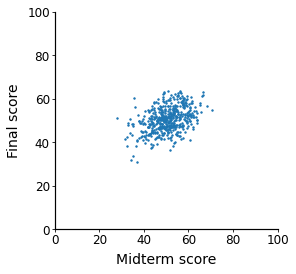

In [ ]:
with mplscience.style_context():
    plt.scatter(midterm_scores, final_scores, s=2)
    plt.xlim(0, 100)
    plt.ylim(0, 100) 
    plt.xlabel('Midterm score')
    plt.ylabel('Final score')

Given this dataset, we are interested in understanding the relationship between midterm scores and final scores. We can do so with a Bayesian Linear Regression model which we will implement in Pyro.

With vanilla regression, we aim to fit a linear function to our data incorporating weights for each feature and a bias.

$$y = wX + b$$

where in this case $y$ is the final score, and $X$ is a scalar representing our midterm score.

In Bayesian Regressian, we additionally introduce a noise term, $\epsilon$, which accounts for uncertainty in our regressian estimate. 

$$y = wX + b + \epsilon$$
$$\textrm{where } \epsilon \sim \textrm{Normal}(0, \sigma^2)$$

Given that our data appears homoskedastic (constant noise relative to input), this is a suitable model for interpreting our data.

In [ ]:
def model(midterm_scores, final_scores):
  final_bias = pyro.sample('bias', dist.Normal(0, 10))
  final_weight = pyro.sample('final_weight', dist.Normal(0, 1))
  sigma = pyro.sample('sigma', dist.Exponential(1.0))

  with pyro.plate('students', midterm_scores.shape[0]):
    pyro.sample('final_score', dist.Normal(midterm_scores * final_weight + final_bias, sigma), obs=final_scores)

We can visualize any Pyro model with the `render_model(...)` method. This is a great way to sanity check that your implementation aligns with your intended graphical model (Note: this feature is only available in v1.8.0+ of Pyro).

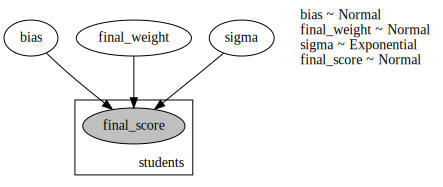

In [ ]:
pyro.render_model(model, model_args=(midterm_scores_t, final_scores_t), render_distributions=True)

Now, we can infer our latent variables by running MCMC. Pyro provides an efficient implementatation of Hamiltonian Monte Carlo called the No-U-Turn Sampler (paper: http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf). We can specify how many warmup steps that we want to take (not included in the final output) and how many post-warmup samples we would like to collect. The main advantage of MCMC inference methods is the accuracy of the predicted posterior. MCMC produces samples from the true posterior of the model, which means if tuned correctly, one can reliably get a good picture of the posterior  regardless of its distribution.

In [ ]:
pyro.clear_param_store()
kernel = pyro.infer.mcmc.NUTS(model, jit_compile=True)
mcmc = pyro.infer.MCMC(kernel, num_samples=500, warmup_steps=500)
mcmc.run(midterm_scores_t, final_scores_t)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 1000/1000 [00:37, 26.60it/s, step size=1.09e-01, acc. prob=0.929]


In [ ]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Text(0.5, 0, 'sigma')

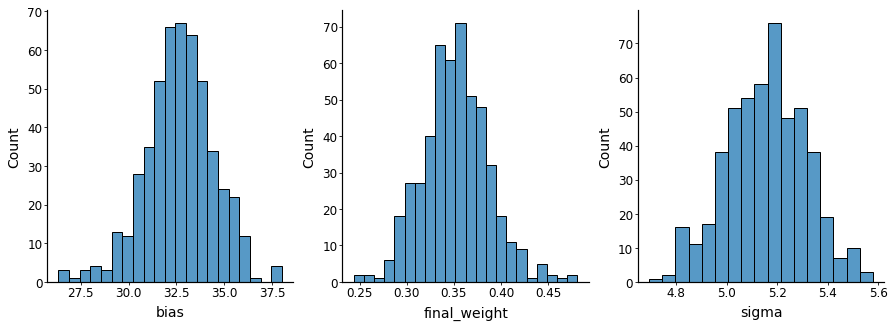

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(mcmc_samples['bias'], ax=axes[0])
axes[0].set_xlabel('bias')

sns.histplot(mcmc_samples['final_weight'].flatten(), ax=axes[1])
axes[1].set_xlabel('final_weight')

sns.histplot(mcmc_samples['sigma'].flatten(), ax=axes[2])
axes[2].set_xlabel('sigma')

Now that we have the MCMC samples of the latent variables, we can plot some realizations of our samples with respect to our data and visually inspect whether it seems to be a good fit.

In [ ]:
x_reg = np.arange(0, 100)
y_reg = x_reg * mcmc_samples['final_weight'].mean() + mcmc_samples['bias'].mean()
sigma = mcmc_samples['sigma'].mean()

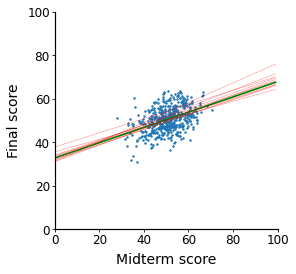

In [ ]:
with mplscience.style_context():
    plt.scatter(midterm_scores, final_scores, s=2)
    plt.xlim(0, 100)
    plt.ylim(0, 100) 
    plt.xlabel('Midterm score')
    plt.ylabel('Final score')
    plt.plot(x_reg, y_reg, c='green')
    for _ in range(10):
      x_random_reg = np.arange(0, 100)
      y_random_reg = x_reg * np.random.choice(mcmc_samples['final_weight']) + np.random.choice(mcmc_samples['bias'])
      plt.plot(x_random_reg, y_random_reg, c='red', linewidth=0.3, alpha=0.8)

Below we plot the linear regression with error bounds of +- 2 standard deviations of the noise term, under the assumption that the mean values of the posterior samples are the true values. Note: these error bounds are not representative of a confidence interval or credible interval, but can visually give us an idea of whether the inferred distribution for `sigma` is in the right ballpark.

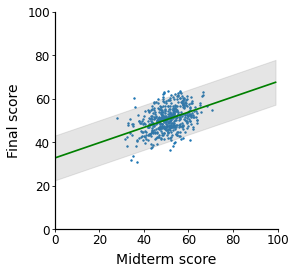

In [ ]:
with mplscience.style_context():
    plt.scatter(midterm_scores, final_scores, s=2)
    plt.xlim(0, 100)
    plt.ylim(0, 100) 
    plt.xlabel('Midterm score')
    plt.ylabel('Final score')
    plt.plot(x_reg, y_reg, c='green')
    plt.fill_between(x_reg, y_reg - 2 * sigma, y_reg + 2 * sigma, color='gray', alpha=0.2)

### Now with Stochastic Variational Inference!

An alternative to MCMC inference methods are variational inference methods. Rather than sampling enough times to get an idea of the true posterior distribution, variational inference methods first define a class of probability distributions, then optimize the parameters of these distributions to match the true posterior as closely as possible. 

The main variational inference method offered in Pyro is called Stochastic Variational Inference (SVI). You can think of it as running stochastic gradient descent over the objective function of variational inference, the ELBO (evidence lower bound objective).

In order to run variational inference in Pyro, you must write a guide function in addition to your model function. The guide function defines your variational distributions and associated parameters that will be optimized with respect to the target posterior distribution. For Pyro to tie these two together, it is crucial that the `sample` and `param` names are consistent across the model and guide.

In [ ]:
def guide(midterm_scores, final_scores):
  map_bias = pyro.param('map_bias', torch.tensor(0.0)) # variational parameter for bias
  pyro.sample('bias', dist.Delta(map_bias)) # MAP inference
  
  final_weight_mean_q = pyro.param('final_weight_mean_q', torch.tensor(0.0)) # variational parameters for final_weight
  final_weight_std_q = pyro.param('final_weight_std_q', torch.tensor(1.0), constraint=torch.distributions.constraints.nonnegative)
  pyro.sample('final_weight', dist.Normal(final_weight_mean_q, final_weight_std_q)) # Normal variational distribution

  sigma_mean_q = pyro.param('sigma_mean_q', torch.tensor(1.0)) # variational parameter for sigma
  pyro.sample('sigma', dist.Normal(sigma_mean_q, torch.tensor(0.05))) # Normal variational distribution


In [ ]:
adam_params = {'lr': 0.05}
optimizer = pyro.optim.ClippedAdam(adam_params)

# setup the inference algorithm
pyro.clear_param_store()
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# do gradient steps
elbos = []
for step in range(1000):
  elbo = svi.step(midterm_scores_t, final_scores_t)
  if step % 10 == 0:
    elbos.append(elbo)
  if step % 100 == 0:
    print(f'Elbo at step {step}: {elbo}')

Elbo at step 0: 2711709.3643373814
Elbo at step 100: 1689.1014051937836
Elbo at step 200: 1685.5697373264675
Elbo at step 300: 1656.5758494329905
Elbo at step 400: 1639.0323501231996
Elbo at step 500: 1627.904301888997
Elbo at step 600: 1615.724357488701
Elbo at step 700: 1602.0318228250628
Elbo at step 800: 1594.1579437892074
Elbo at step 900: 1583.5771674464727


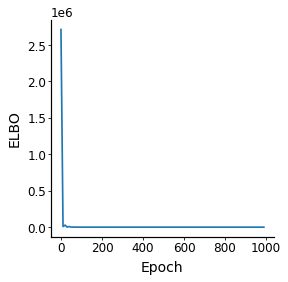

In [ ]:
with mplscience.style_context():
  plt.plot(10 * np.arange(len(elbos)), elbos)
  plt.xlabel("Epoch")
  plt.ylabel("ELBO")

In [ ]:
print(f"Bias: {pyro.param('map_bias').item()}")
print(f"Final weight q dist: Normal({pyro.param('final_weight_mean_q').item()}, {pyro.param('final_weight_std_q').item()}")
print(f"Sigma Mean: {pyro.param('sigma_mean_q').item()}")

Bias: 19.57647132873535
Final weight q dist: Normal(0.6001940369606018, 0.0045984466560184956
Sigma Mean: 5.509418964385986


In [ ]:
n_predictive_samples = 1000
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=n_predictive_samples)
svi_samples = {k: v.reshape(n_predictive_samples).detach().cpu().numpy()
               for k, v in predictive(midterm_scores_t, final_scores_t).items() if k in ['final_weight']}

Text(0.5, 1.0, 'posterior predictive')

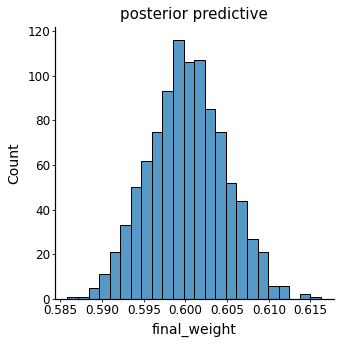

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.histplot(svi_samples['final_weight'].flatten(), ax=ax)
ax.set_xlabel('final_weight')
ax.set_title('posterior predictive')

In [ ]:
x_reg_svi = np.arange(0, 100)
y_reg_svi = x_reg_svi * pyro.param('final_weight_mean_q').item() + pyro.param('map_bias').item()
sigma_reg_svi = pyro.param('sigma_mean_q').item()

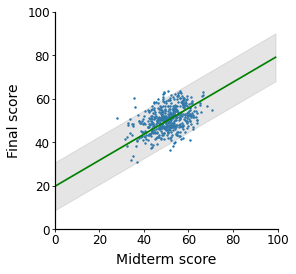

In [ ]:
with mplscience.style_context():
    plt.scatter(midterm_scores, final_scores, s=2)
    plt.xlim(0, 100)
    plt.ylim(0, 100) 
    plt.xlabel('Midterm score')
    plt.ylabel('Final score')
    plt.plot(x_reg_svi, y_reg_svi, c='green')
    plt.fill_between(x_reg_svi, y_reg_svi - 2 * sigma_reg_svi, y_reg_svi + 2 * sigma_reg_svi, color='gray', alpha=0.2)

## Using AutoGuides

Via Automatic Differentiation Variational Inference (https://arxiv.org/abs/1603.00788), Pyro can automatically generate a guide for a given model. In this case, we will use the AutoDiagonalNormal AutoGuide which uses a multivariate Gaussian distribution with a diagonal covariance matrix to approximate the posterior distribution. In order to minimize the KL divergence between our variational distribution and the tru posterior, we must ensure that the support of the variational distribution is a strict subset of the true posterior support. In order to guarantee this, Pyro maps the model variable distributions to the unconstrained real space.

Beyond the AutoDiagonalNormal AutoGuide, Pyro offers several other choices. For example, the AutoMultivariateNormal is a full rank version of the AutoDiagonalNormal AutoGuide. This relaxes the mean-field assumption that is implicitly made when using the AutoDiagonalNormal guide. They can all be found detailed [here](https://docs.pyro.ai/en/stable/infer.autoguide.html).

In [ ]:
# We use the same model as above.

adam_params = {'lr': 0.05}
optimizer = pyro.optim.ClippedAdam(adam_params)

# setup the inference algorithm
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# do gradient steps
elbos = []
for step in range(1000):
  elbo = svi.step(midterm_scores_t, final_scores_t)
  if step % 10 == 0:
    elbos.append(elbo)
  if step % 100 == 0:
    print(f'Elbo at step {step}: {elbo}')

Elbo at step 0: 1479942.0826857972
Elbo at step 100: 1663.7646354781264
Elbo at step 200: 1644.798524752057
Elbo at step 300: 1640.9976815427478
Elbo at step 400: 1629.023089147226
Elbo at step 500: 1611.835976134979
Elbo at step 600: 1606.9996962173204
Elbo at step 700: 1599.3924201757332
Elbo at step 800: 1594.7912956845685
Elbo at step 900: 1585.8639159131774


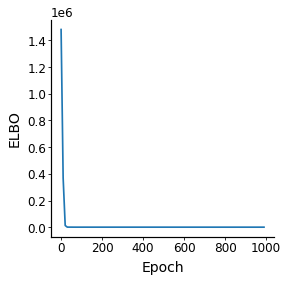

In [ ]:
with mplscience.style_context():
  plt.plot(10 * np.arange(len(elbos)), elbos)
  plt.xlabel("Epoch")
  plt.ylabel("ELBO")

We can now inspect the inferred posterior distribution via the `guide.quantiles` method which takes the learned distributions and maps them back to the original support of the model prior distributions.

In [ ]:
quantiles = {k:v.detach().numpy() for k, v in guide.quantiles([0.25, 0.5, 0.75]).items()}
quantiles

{'bias': array([19.768734, 19.957918, 20.147102], dtype=float32),
 'final_weight': array([0.6183549 , 0.6209757 , 0.62359643], dtype=float32),
 'sigma': array([5.6512375, 5.7555404, 5.8617682], dtype=float32)}

In [ ]:
x_reg_auto = np.arange(0, 100)
y_reg_auto = x_reg_auto * quantiles['final_weight'][2] + quantiles['bias'][2]
sigma_reg_auto = quantiles['sigma'][2]

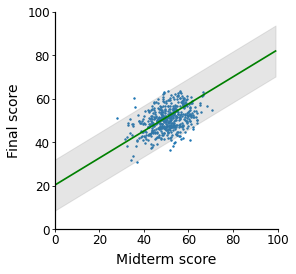

In [ ]:
with mplscience.style_context():
    plt.scatter(midterm_scores, final_scores, s=2)
    plt.xlim(0, 100)
    plt.ylim(0, 100) 
    plt.xlabel('Midterm score')
    plt.ylabel('Final score')
    plt.plot(x_reg_auto, y_reg_auto, c='green')
    plt.fill_between(x_reg_auto, y_reg_auto - 2 * sigma_reg_auto, y_reg_auto + 2 * sigma_reg_auto, color='gray', alpha=0.2)

We see similar results to with our handwritten guide, but without having to write a guide! However, autoguides should not be used carelessly in every situation since they are restrictive, black-box, and make implicit assumptions about a good variational distribution family. 